In [1]:
!nvidia-smi

Sat Oct 26 20:41:56 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2070 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   80C    P0             43W /   80W |    2111MiB /   8192MiB |      9%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
%pip install --extra-index-url=https://pypi.nvidia.com cudf-cu12
%pip install cucim-cu12 cupy-cuda12x dask-cuda 

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
%load_ext cudf.pandas

In [4]:

from cucim.skimage.exposure import rescale_intensity
import tensorflow as tf
import cupy as cp
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import glob

print("Is torch using cuda? ",torch.cuda.is_available())
print("Is cupy using cuda? ",cp.cuda.is_available())
print("Is tensorflow using cuda? ",tf.test.is_built_with_cuda())
print("Is pandas using cuda? ",pd)


2024-10-26 20:42:03.062483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-26 20:42:03.083406: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-26 20:42:03.091784: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-26 20:42:03.110039: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Is torch using cuda?  True
Is cupy using cuda?  True
Is tensorflow using cuda?  True
Is pandas using cuda?  <module 'pandas' (ModuleAccelerator(fast=cudf, slow=pandas))>


In [5]:

base_path = '/home/workspace/geometry-classifier/data/'

csv_files = glob.glob(base_path+'photos_v1/*.csv')

def nextDf():
    i = 0
    while i < len(csv_files):
        chuncks = [pd.read_csv(file) for file in csv_files[i:i+4]]
        df = pd.concat(chuncks)
        yield df
        del df
        i += 4

dfGenerator = nextDf()
df = next(dfGenerator)

In [23]:
image_row = df.iloc[0, 1:].values

# Reshape the flattened row into a 2D array (for a 224x224 image)
image_reshaped = image_row.reshape(256, 256)

In [24]:
# converr to float
image_reshaped = image_reshaped.astype(float)

In [25]:
df.head()

,pyramid_35_0_0,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.63658,0.63659,0.63660,0.63661,0.63662,0.63663,0.63664,0.63665,0.63666,0.63667
0,pyramid_35_0_1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,pyramid_35_0_2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,pyramid_35_0_3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,pyramid_35_0_4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,pyramid_35_0_5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


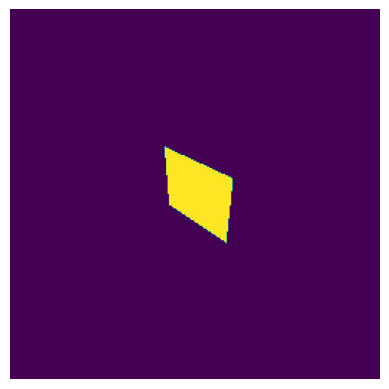

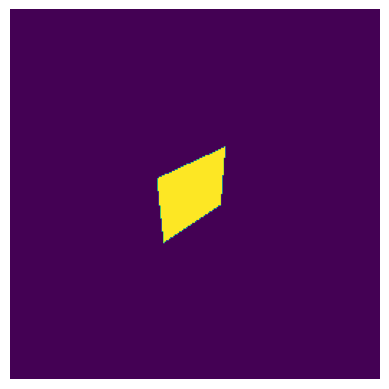

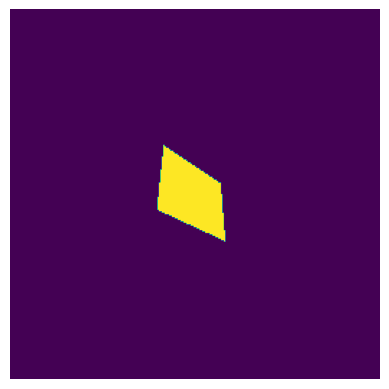

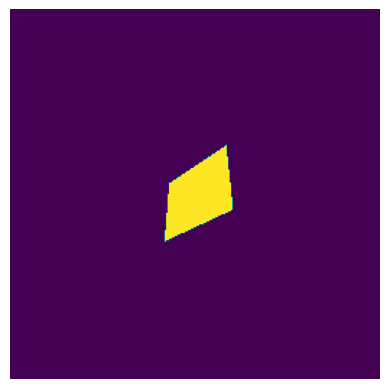

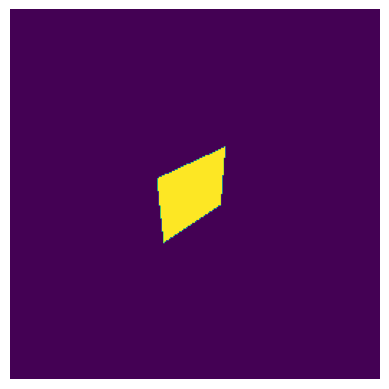

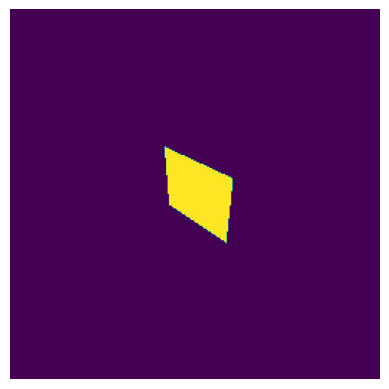

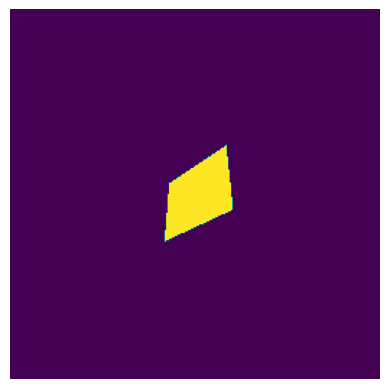

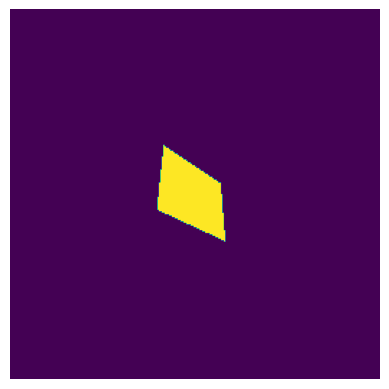

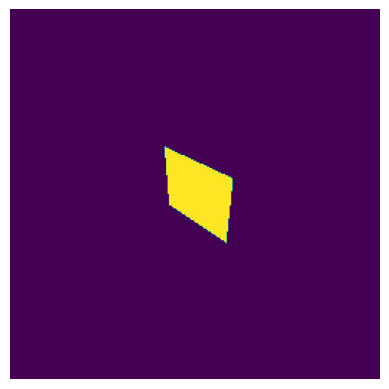

In [26]:

for i in range(1, 10):
    image_row = df.iloc[i, 1:].values
    image_reshaped = image_row.reshape(256, 256).astype(float)
    
    plt.imshow(image_reshaped)
    plt.axis('off')
    plt.show()

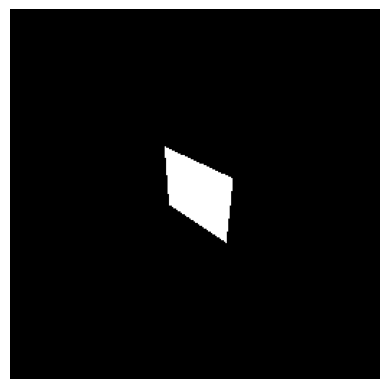

In [27]:
#df = pd.DataFrame([[int(128)] * (256 * 256)])  # Example row with pixel values between 0 and 255


# Render the image using matplotlib
plt.imshow(image_reshaped, cmap='gray')  # Set vmin and vmax to handle the full 0-255 range
plt.axis('off')  # Optionally turn off the axis
plt.show()

In [28]:
df.head()

,pyramid_35_0_0,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.63658,0.63659,0.63660,0.63661,0.63662,0.63663,0.63664,0.63665,0.63666,0.63667
0,pyramid_35_0_1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,pyramid_35_0_2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,pyramid_35_0_3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,pyramid_35_0_4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,pyramid_35_0_5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
#from sklearn.grid_search import GridSearchCV
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import applications as cnns
from tensorflow.keras.preprocessing.image import smart_resize
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten

In [30]:
#list_of_models = []

"""
def create_model_VGG16(optimizer='adam'):
    model = cnns.VGG16(include_top=False, input_shape=(256, 256, 3))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def create_model_ResNet50(optimizer='adam'):
    model = cnns.ResNet50(include_top=False, input_shape=(256, 256, 3))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
"""

base_model = cnns.MobileNet(include_top=True, weights="imagenet" ,input_shape=(224, 224, 3))
x = base_model.output
x = Flatten(name="custom_flatten")(x)
x = Dense(1024, activation="relu", name="custom_dense")(x)
pred = Dense(1000, activation="softmax", name="custom_pred")(x)


model = Model(inputs=base_model.input, outputs=pred)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



I0000 00:00:1729648992.882418      12 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729648992.947209      12 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729648992.947502      12 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729648992.950056      12 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
def process_df(df):
    gray_img = cp.array(df.to_pandas())  # Convert to a CuPy array
    # Step 1: Resize to 224x224
    # Rescale intensity if needed
    gray_img_resized = rescale_intensity(cp.asarray(gray_img), out_shape=(224, 224))

    # Step 2: Convert grayscale to RGB by stacking the array 3 times along a new axis
    rgb_img = cp.stack([gray_img_resized]*3, axis=-1)

    # Optionally, you can convert back to cuDF if you need a DataFrame format
    rgb_df = pd.DataFrame.from_records(rgb_img.reshape(-1, 3), columns=["R", "G", "B"])
    return rgb_df


: 

: 

In [ ]:
while True:
    df = next(dfGenerator)
    if df.empty:
        break
    

In [31]:
df_ranges = 3

results = []
results_per_geometry = []

for i in range(1, df_ranges):
    print("Csv number: ", i)
    df = next(dfGenerator)
    j=0
    results_of_geometry = (()*8)
    for image in df.iterrows():
        if j==8:
            j=0
            results_per_geometry.append(results_of_geometry)
            results_of_geometry = (()*8)
            
        target = re.sub(r"(_.*)","",image[1][0])
        image_row = image[1][1:].values
        image_row = image_row.reshape(256, 256).astype(float)
        image_row = np.expand_dims(image_row, axis=-1)
        image_reshaped = smart_resize(image_row, (224, 224))
        image_reshaped = np.repeat(image_reshaped, 3, axis=-1)
        image_reshaped = np.expand_dims(image_reshaped, axis=0)
        results.append((model.predict(image_reshaped), target))
        results_of_geometry[j] = (model.predict(image_reshaped), target)
        j+=1
        
    del df


Csv number:  1


/tmp/ipykernel_12/2049077395.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  target = re.sub(r"(_.*)","",image[1][0])
I0000 00:00:1729649120.041468     110 service.cc:146] XLA service 0x730d28022210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729649120.041508     110 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 with Max-Q Design, Compute Capability 7.5
2024-10-23 02:05:20.095290: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-23 02:05:20.445527: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


I0000 00:00:1729649122.336304     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


TypeError: 'tuple' object does not support item assignment

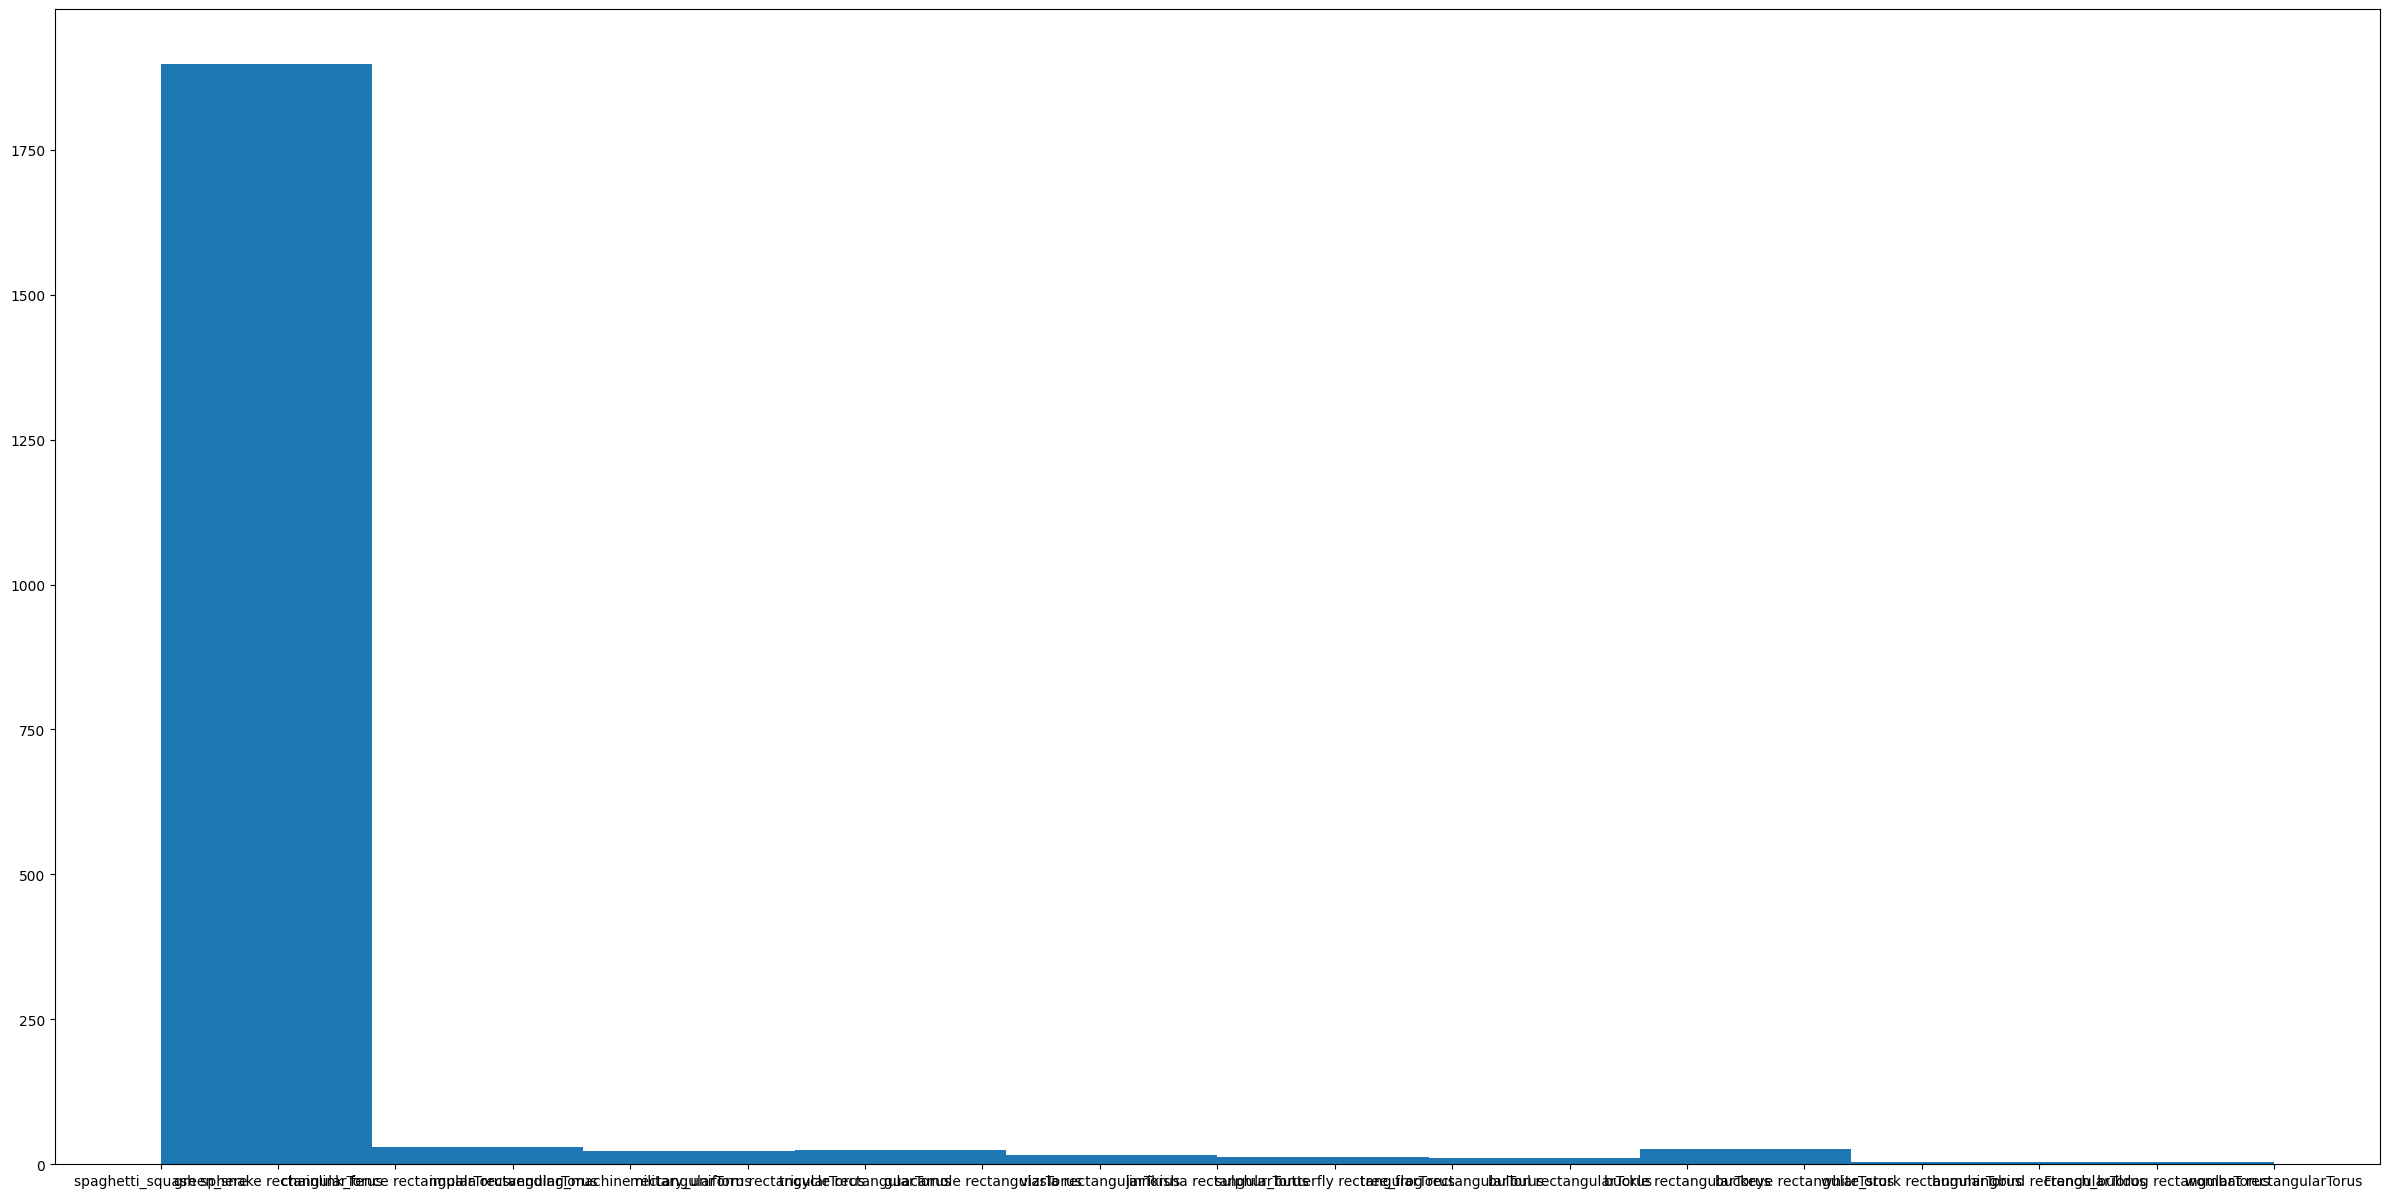

In [ ]:
a = cnns.resnet50.decode_predictions(results[0][0], top=1)
decoder = cnns.mobilenet.decode_predictions
results_decoded = [(decoder(res[0], top=1)[0][0][1],res[1]) for res in results]

decoded_for_plot = [str(res[0]) + " "+ str(res[1]) for res in results_decoded]

plt.figure(figsize=(30, 15))
plt.hist(decoded_for_plot)
plt.show()
